# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/datasets/ealaxi/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [3]:
# Your code here
import pandas as pd

data = pd.read_csv(r'C:\Users\Daniel Carvalho\Desktop\DataAnalysis\WEEK7\DAY4\labs\lab-imbalance\PS_20174392719_1491204439457_log.csv').sample(n=100000)
data.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5259140,372,TRANSFER,137349.44,C1560961106,142014.0,4664.56,C638692766,17049.88,154399.32,0,0
1942882,177,PAYMENT,35990.52,C114424857,0.0,0.00,M148384449,0.00,0.00,0,0
3623533,274,PAYMENT,95.95,C987734662,19248.0,19152.05,M2036089522,0.00,0.00,0,0


### What is the distribution of the outcome? 

In [9]:
data['isFraud'].value_counts()

0    99865
1      135
Name: isFraud, dtype: int64

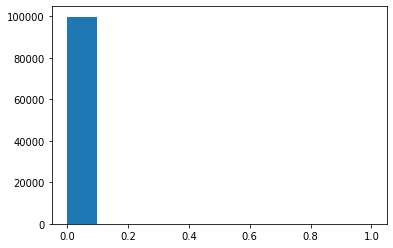

In [7]:
# Your response here
import matplotlib.pyplot as plt
plt.hist(data['isFraud'])
plt.show()

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [10]:
# Your code here
data.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022924,-0.011487,-0.011557,0.024719,0.023271,0.032341,NaN
amount,0.022924,1.000000,-0.005262,-0.009000,0.303607,0.473470,0.063983,NaN
oldbalanceOrg,-0.011487,-0.005262,1.000000,0.998966,0.063826,0.039185,0.005648,NaN
newbalanceOrig,-0.011557,-0.009000,0.998966,1.000000,0.065541,0.039345,-0.010291,NaN
oldbalanceDest,0.024719,0.303607,0.063826,0.065541,1.000000,0.976133,-0.007597,NaN
newbalanceDest,0.023271,0.473470,0.039185,0.039345,0.976133,1.000000,-0.003181,NaN
isFraud,0.032341,0.063983,0.005648,-0.010291,-0.007597,-0.003181,1.000000,NaN
isFlaggedFraud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Run a logisitc regression classifier and evaluate its accuracy.

In [16]:
# Your code here
from sklearn.linear_model import LogisticRegression

X = pd.DataFrame(data['amount'])
y = pd.Series(data['isFraud'], name='labels')

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)

model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.99868

### Now pick a model of your choice and evaluate its accuracy.

In [18]:
# Your code here
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train,y_train)
tree.score(X_test,y_test)

0.99764

### Which model worked better and how do you know?

In [2]:
# Your response here
#the logistic regression as the decision tree is slightly over fiited

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.